In [1]:
import matplotlib.pyplot as plt
from pyspark import SparkFiles
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.functions import when
from pyspark.ml.feature import VectorAssembler, StringIndexer, IndexToString
from pyspark.sql.types import StructType, StructField
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import DoubleType, IntegerType, StringType


spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [2]:
schema = StructType([
    StructField("fixed acidity", DoubleType()),
    StructField("volatile acidity", DoubleType()),
    StructField("citric acid", DoubleType()),
    StructField("residual sugar", DoubleType()),
    StructField("chlorides", DoubleType()),
    StructField("free sulfur dioxide", DoubleType()),
    StructField("total sulfur dioxide", DoubleType()),
    StructField("density", DoubleType()),
    StructField("pH", DoubleType()),
    StructField("sulphates", DoubleType()),
    StructField("alcohol", DoubleType()),
    StructField("quality", StringType()),
])


In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
spark.sparkContext.addFile(url)
data = spark.read.csv(SparkFiles.get("winequality-red.csv"), header=True, sep=";",schema=schema)

In [4]:
data.show(5)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|
|         11.2|            0.28|       0.56|           1.9|    0.075|               17.0|           

In [5]:
data.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: string (nullable = true)



In [6]:
df = data.toPandas()

In [7]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

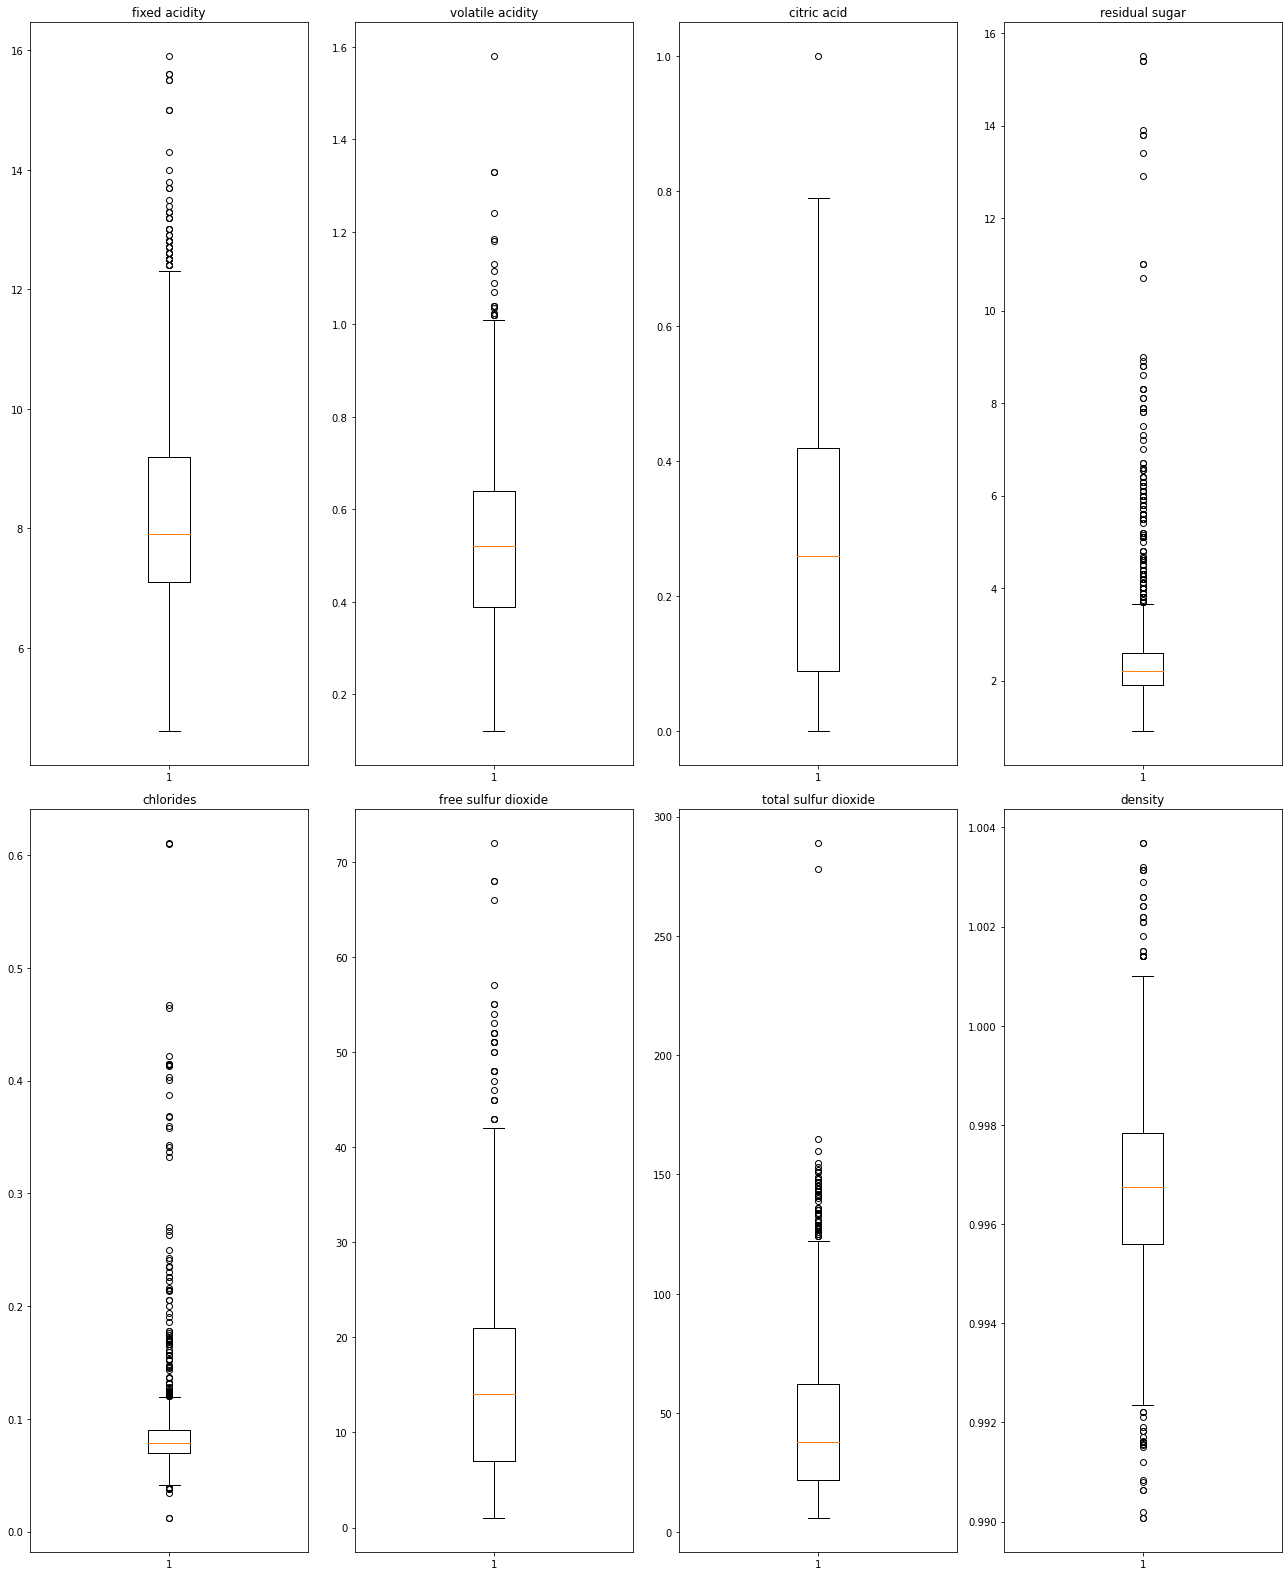

In [8]:
plt.figure(figsize=(18,22))
for item in range(0,8):
    plt.subplot(2,4,item+1)
    plt.boxplot(df.iloc[:,[item]])
    plt.title(df.columns[item])
plt.tight_layout()

In [9]:
del df

## Let's run a RandomForestClassifier without outliers treatment.

In [10]:
# Index qualitys, adding metadata to the quality column.
# Fit on whole dataset to include all qualitys in index.
qualityIndexer = StringIndexer(inputCol="quality", outputCol="indexedquality").fit(data)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
assembler=VectorAssembler(inputCols=['fixed acidity',
                                     'volatile acidity',
                                     'citric acid',
                                     'residual sugar',
                                     'chlorides',
                                     'free sulfur dioxide',
                                     'total sulfur dioxide',
                                     'density',
                                     'pH',
                                     'sulphates',
                                     'alcohol'],
                                  outputCol='features')
#data=assembler.transform(data)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.8, 0.2])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedquality", featuresCol="features", numTrees=30,
                            seed=42,maxDepth=10)

# Convert indexed qualitys back to original qualitys.
qualityConverter = IndexToString(inputCol="prediction", outputCol="predictedquality",
                               labels=qualityIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[qualityIndexer, assembler, rf, qualityConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("predictedquality", "quality", "features").show(5)

# Select (prediction, true quality) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedquality", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))
print("Accuracy", accuracy)
rfModel = model.stages[2]
print(rfModel)  # summary only

+----------------+-------+--------------------+
|predictedquality|quality|            features|
+----------------+-------+--------------------+
|               5|      6|[4.7,0.6,0.17,2.3...|
|               7|      7|[5.1,0.585,0.0,1....|
|               6|      6|[5.2,0.49,0.26,2....|
|               6|      6|[5.2,0.645,0.0,2....|
|               7|      7|[5.3,0.47,0.11,2....|
+----------------+-------+--------------------+
only showing top 5 rows

Test Error = 0.347181
Accuracy 0.6528189910979229
RandomForestClassificationModel: uid=RandomForestClassifier_ffac0322fb70, numTrees=30, numClasses=6, numFeatures=11


In [11]:
for col in data.columns[:-1:]:

    data = data.withColumn(col, when(data[col] >= \
            data.approxQuantile(col, [0.75],0.20)[0],
            data.approxQuantile(col, [0.75],0.20)[0]).otherwise(data[col]))


# Checking if the treatment worked

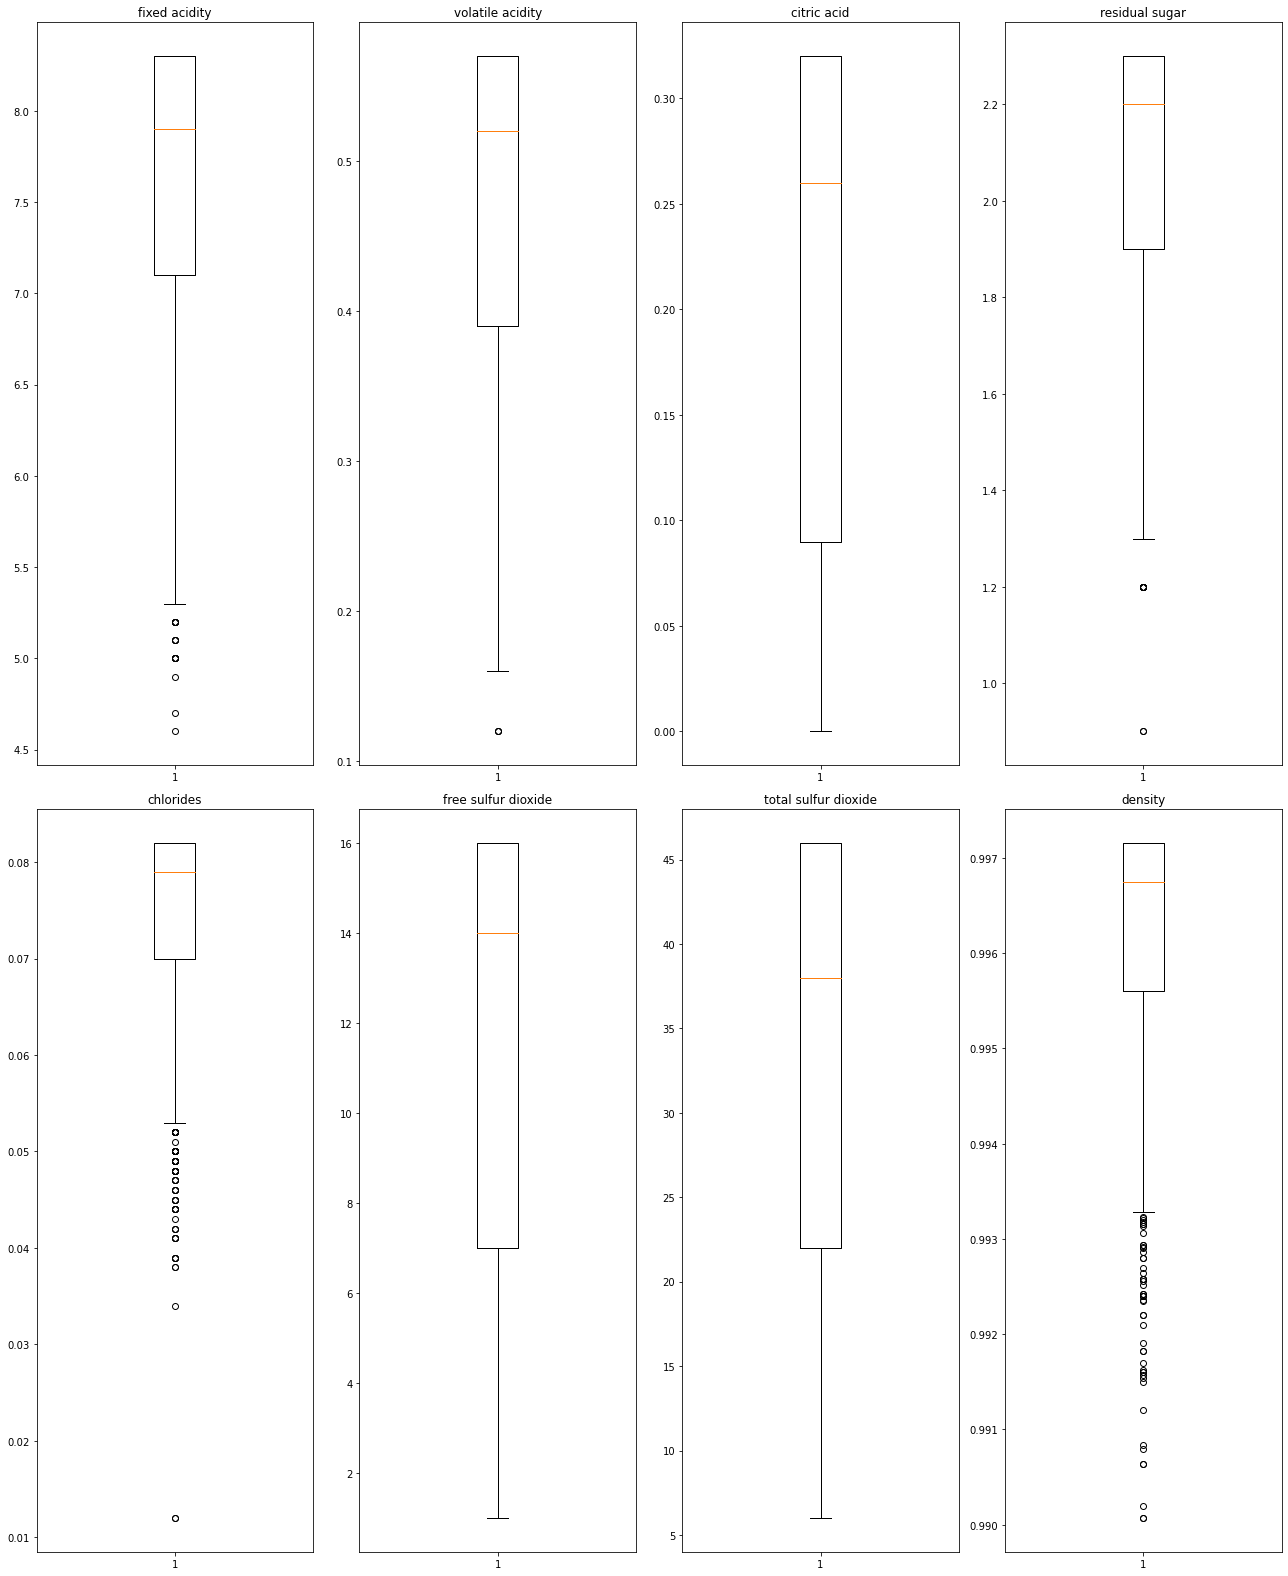

In [12]:
df = data.toPandas()
plt.figure(figsize=(18,22))
for item in range(0,8):
    plt.subplot(2,4,item+1)
    plt.boxplot(df.iloc[:,[item]])
    plt.title(df.columns[item])
plt.tight_layout()

In [13]:
# Index qualitys, adding metadata to the quality column.
# Fit on whole dataset to include all qualitys in index.
qualityIndexer = StringIndexer(inputCol="quality", outputCol="indexedquality").fit(data)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
assembler=VectorAssembler(inputCols=['fixed acidity',
                                     'volatile acidity',
                                     'citric acid',
                                     'residual sugar',
                                     'chlorides',
                                     'free sulfur dioxide',
                                     'total sulfur dioxide',
                                     'density',
                                     'pH',
                                     'sulphates',
                                     'alcohol'],
                                  outputCol='features')
#data=assembler.transform(data)

# Split the data into training and test sets (20% held out for testing)
(trainingData, testData) = data.randomSplit([0.8, 0.2])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedquality", featuresCol="features", numTrees=30,
                           seed=42,maxDepth=10)

# Convert indexed qualitys back to original qualitys.
qualityConverter = IndexToString(inputCol="prediction", outputCol="predictedquality",
                               labels=qualityIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[qualityIndexer, assembler, rf, qualityConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("predictedquality", "quality", "features").show(5)

# Select (prediction, true quality) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedquality", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))
print("Accuracy", accuracy)
rfModel = model.stages[2]
print(rfModel)  # summary only

+----------------+-------+--------------------+
|predictedquality|quality|            features|
+----------------+-------+--------------------+
|               5|      4|[4.6,0.52,0.15,2....|
|               6|      6|[5.1,0.47,0.02,1....|
|               7|      7|[5.1,0.51,0.18,2....|
|               5|      5|[5.2,0.32,0.25,1....|
|               6|      7|[5.2,0.48,0.04,1....|
+----------------+-------+--------------------+
only showing top 5 rows

Test Error = 0.318043
Accuracy 0.6819571865443425
RandomForestClassificationModel: uid=RandomForestClassifier_988bfa91ed74, numTrees=30, numClasses=6, numFeatures=11
